<a href="https://colab.research.google.com/github/femketenharkel/Predicting_Ratings/blob/main/Error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Error analysis**

# K-Means clustering + Extreme Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

In [2]:
drive.mount('/content/drive')
df_final = pd.read_csv('/content/drive/My Drive/Thesis/Data/df_final_K-Means_clustering4.csv')
model = joblib.load("/content/drive/My Drive/Thesis/Models/K-Means_XGB.pkl")

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:31:01] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [3]:
# Define feature and target
X = df_final.drop(columns=['Rating'])
y = df_final['Rating']

from sklearn.preprocessing import LabelEncoder
# Assuming you have a label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# Predict on the test set
test_predictions = model.predict(X_test)

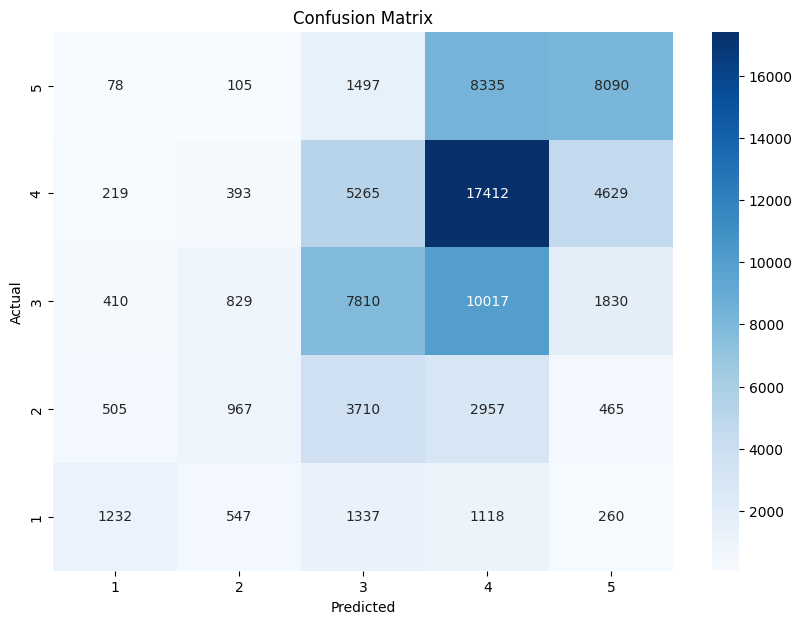

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.show()

conf matrix 2.0

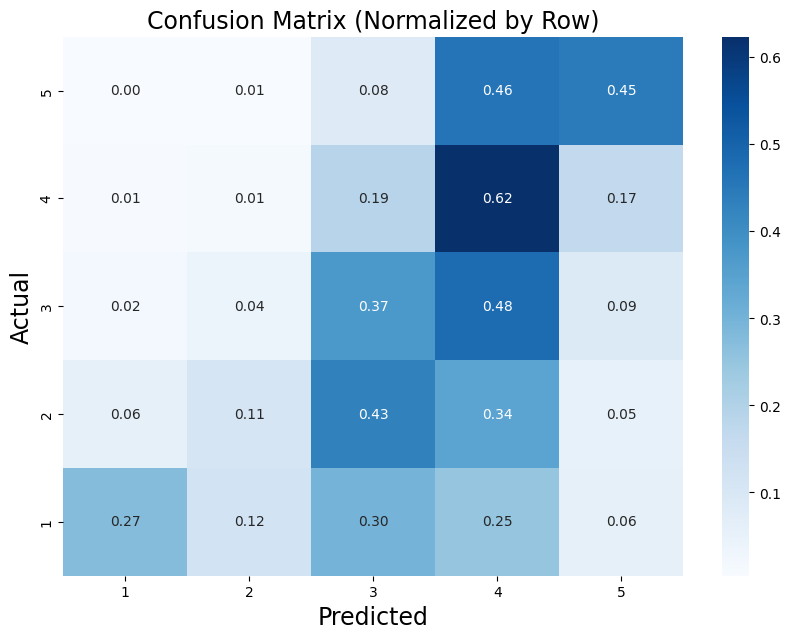

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class_names = model.classes_

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Normalize the confusion matrix by row (i.e., by the number of samples in each actual class)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Adjust class names from 0-4 to 1-5
class_names = [1, 2, 3, 4, 5]

# Plot the confusion matrix with row-wise normalization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize = 17)
plt.ylabel('Actual', fontsize = 17)
plt.title('Confusion Matrix (Normalized by Row)', fontsize = 17)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.show()

ROC AUC Scores for each class:
1: 0.6290
2: 0.5431
3: 0.5870
4: 0.5966
5: 0.6654


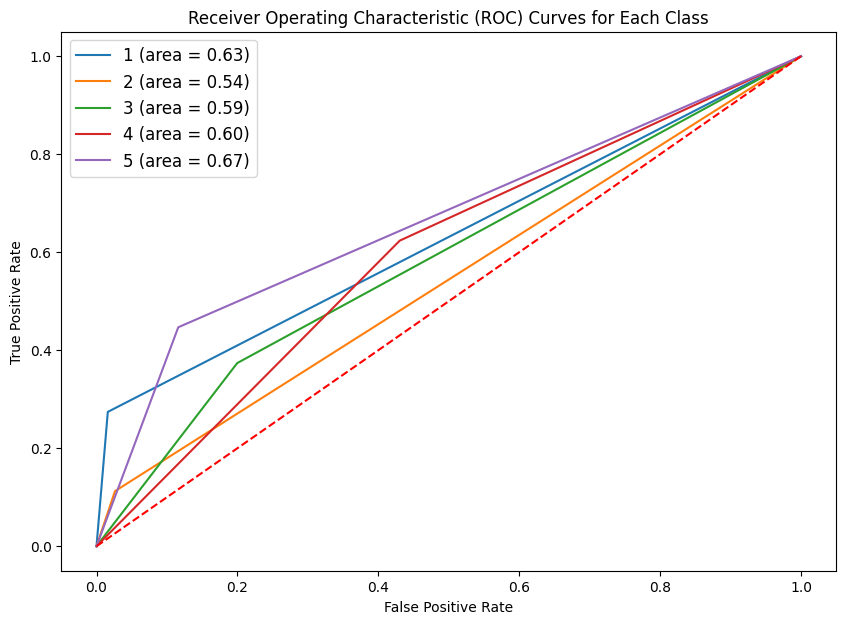

In [ ]:
# Binarize the output for multi-class ROC AUC and other metrics
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
test_predictions_bin = label_binarize(test_predictions, classes=range(len(class_names)))

# ROC AUC Score for each class
roc_auc_dict = {}
for i in range(len(class_names)):
    roc_auc_dict[class_names[i]] = roc_auc_score(y_test_bin[:, i], test_predictions_bin[:, i])

print("ROC AUC Scores for each class:")
for class_name, score in roc_auc_dict.items():
    print(f"{class_name}: {score:.4f}")

# ROC Curves for each class
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_predictions_bin[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_dict[class_names[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
plt.legend(fontsize='large')
plt.grid(False)
plt.show()

In [ ]:
# Log Loss
logloss = log_loss(y_test_bin, test_predictions_bin)
print(f"Log Loss: {logloss:.4f}")

# Brier Score Loss for each class
brier_scores = {}
for i in range(len(class_names)):
    brier_scores[class_names[i]] = brier_score_loss(y_test_bin[:, i], test_predictions_bin[:, i])

print("Brier Scores for each class:")
for class_name, score in brier_scores.items():
    print(f"{class_name}: {score:.4f}")

Log Loss: 20.0477
Brier Scores for each class:
1: 0.0559
2: 0.1189
3: 0.3111
4: 0.4116
5: 0.2149


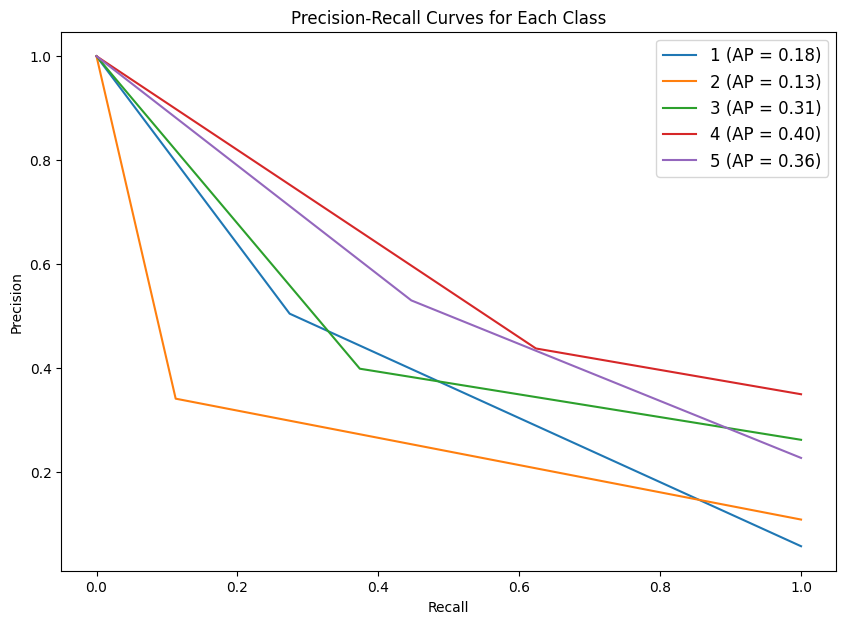

In [ ]:
# Binarize the output for multi-class Precision-Recall curves
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
test_predictions_bin = label_binarize(test_predictions, classes=range(len(class_names)))

# Precision-Recall curves for each class
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], test_predictions_bin[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], test_predictions_bin[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(fontsize='large')
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import zero_one_loss

zero_one = zero_one_loss(y_test, test_predictions)
print(f"Zero-One Loss: {zero_one:.4f}")

Zero-One Loss: 0.5562


In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test, test_predictions, target_names=class_names, output_dict=True)
for class_name, metrics in class_report.items():
    if class_name != 'accuracy':
        print(f"Class: {class_name}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")

Class: 1
  precision: 0.50
  recall: 0.27
  f1-score: 0.36
  support: 4494.00
Class: 2
  precision: 0.34
  recall: 0.11
  f1-score: 0.17
  support: 8604.00
Class: 3
  precision: 0.40
  recall: 0.37
  f1-score: 0.39
  support: 20896.00
Class: 4
  precision: 0.44
  recall: 0.62
  f1-score: 0.51
  support: 27918.00
Class: 5
  precision: 0.53
  recall: 0.45
  f1-score: 0.48
  support: 18105.00
Class: macro avg
  precision: 0.44
  recall: 0.37
  f1-score: 0.38
  support: 80017.00
Class: weighted avg
  precision: 0.44
  recall: 0.44
  f1-score: 0.43
  support: 80017.00


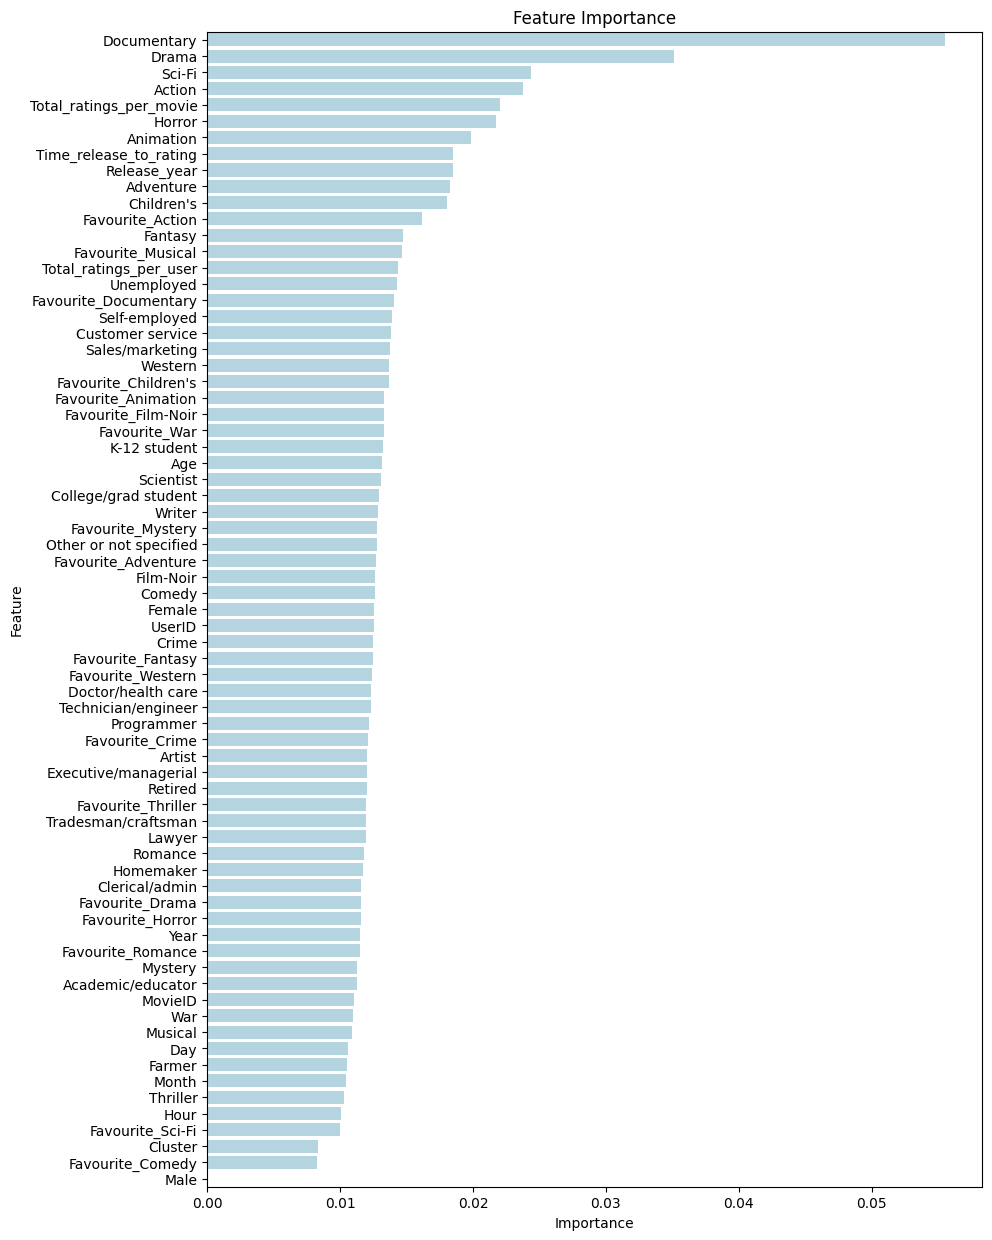

In [ ]:
# Feature Importance
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    features = X.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 15))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='lightblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()
else:
    print("The model does not have feature_importances_ attribute.")

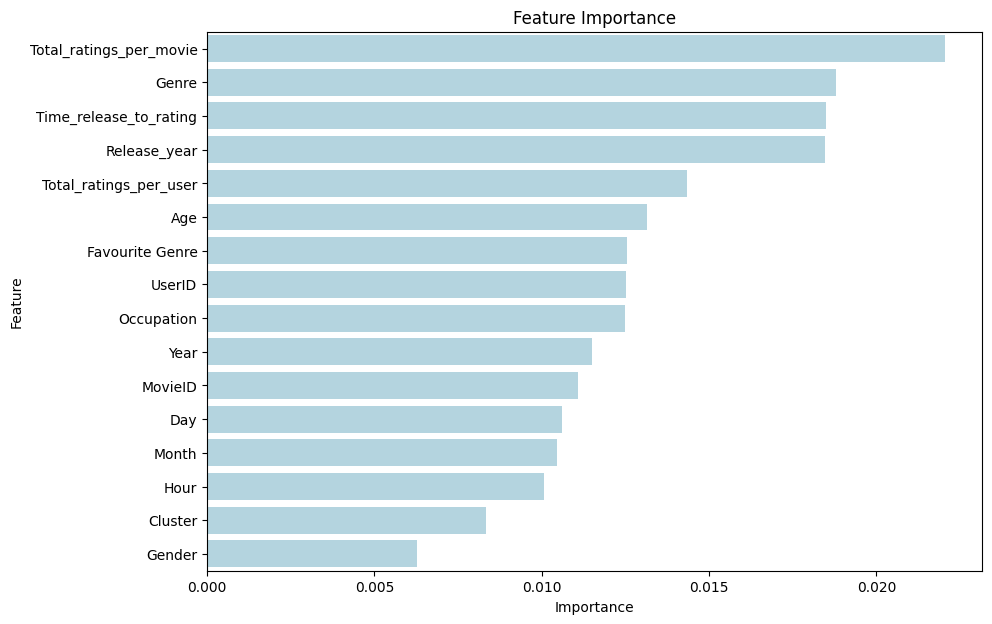

In [ ]:
# Feature Importance
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    features = X.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # List of genre features to average
    genre_features = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
                      'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                      'Sci-Fi', 'Thriller', 'War', 'Western']

    # Calculate the average importance of genre features
    genre_importance_avg = feature_importance_df[feature_importance_df['Feature'].isin(genre_features)]['Importance'].mean()

    # Remove the individual genre features
    feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(genre_features)]

    # Add the average importance of genre features to the DataFrame
    genre_importance_df = pd.DataFrame({'Feature': ['Genre'], 'Importance': [genre_importance_avg]})
    feature_importance_df = pd.concat([feature_importance_df, genre_importance_df], ignore_index=True)




    # List of favourite genre features to average
    favourite_genre_features = ['Favourite_Action', 'Favourite_Adventure', 'Favourite_Animation', "Favourite_Children's",
                                'Favourite_Comedy', 'Favourite_Crime', 'Favourite_Documentary', 'Favourite_Drama',
                                'Favourite_Fantasy', 'Favourite_Film-Noir', 'Favourite_Horror', 'Favourite_Musical',
                                'Favourite_Mystery', 'Favourite_Romance', 'Favourite_Sci-Fi', 'Favourite_Thriller',
                                'Favourite_War', 'Favourite_Western']

    # Calculate the average importance of favourite genre features
    favourite_genre_importance_avg = feature_importance_df[feature_importance_df['Feature'].isin(favourite_genre_features)]['Importance'].mean()

    # Remove the individual favourite genre features
    feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(favourite_genre_features)]

    # Add the average importance of favourite genre features to the DataFrame
    favourite_genre_importance_df = pd.DataFrame({'Feature': ['Favourite Genre'], 'Importance': [favourite_genre_importance_avg]})
    feature_importance_df = pd.concat([feature_importance_df, favourite_genre_importance_df], ignore_index=True)




    # List of genre features to average
    gender_features = ['Female', 'Male']

    # Calculate the average importance of genre features
    gender_importance_avg = feature_importance_df[feature_importance_df['Feature'].isin(gender_features)]['Importance'].mean()

    # Remove the individual genre features
    feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(gender_features)]

    # Add the average importance of genre features to the DataFrame
    gender_importance_df = pd.DataFrame({'Feature': ['Gender'], 'Importance': [gender_importance_avg]})
    feature_importance_df = pd.concat([feature_importance_df, gender_importance_df], ignore_index=True)



    # List of occupation features
    occupation_features = ['Other or not specified', 'Academic/educator', 'Artist',
                           'Clerical/admin', 'College/grad student',  'Customer service',
                           'Doctor/health care', 'Executive/managerial', 'Farmer', 'Homemaker',
                           'K-12 student', 'Lawyer', 'Programmer', 'Retired', 'Sales/marketing',
                           'Scientist', 'Self-employed', 'Technician/engineer', 'Tradesman/craftsman',
                           'Unemployed', 'Writer']

    # Calculate the average importance of favourite genre features
    occupation_importance_avg = feature_importance_df[feature_importance_df['Feature'].isin(occupation_features)]['Importance'].mean()

    # Remove the individual favourite genre features
    feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(occupation_features)]

    # Add the average importance of favourite genre features to the DataFrame
    occupation_importance_avg = pd.DataFrame({'Feature': ['Occupation'], 'Importance': [occupation_importance_avg]})
    feature_importance_df = pd.concat([feature_importance_df, occupation_importance_avg], ignore_index=True)

    # Add the occupation features back to the DataFrame if they exist in the original DataFrame
    for occupation in occupation_features:
        occupation_feature = f'Occupation_{occupation}'
        if occupation_feature in features:
            occupation_importance = feature_importances[features.get_loc(occupation_feature)]
            occupation_importance_df = pd.DataFrame({'Feature': [occupation_feature], 'Importance': [occupation_importance]})
            feature_importance_df = pd.concat([feature_importance_df, occupation_importance_df], ignore_index=True)

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color = "lightblue")
    plt.title('Feature Importance')
    plt.grid(False)
    plt.show()
else:
    print("The model does not have feature_importances_ attribute.")

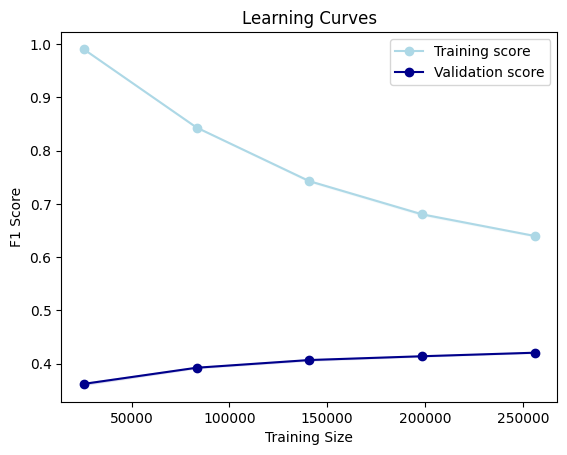

In [ ]:
def plot_learning_curves(model, X, y, cv=5, scoring='f1_weighted'):
    # Generate learning curves
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='lightblue', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='darkblue', label='Validation score')

    # Fill between the mean ± std deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='lightblue')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color='darkblue')

    # Add labels and legend
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')

    # Show plot
    plt.show()


plot_learning_curves(model, X_train, y_train)

# Extreme Gradient Boosting baseline

In [ ]:
import pandas as pd
import joblib
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, brier_score_loss
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score


In [ ]:
drive.mount('/content/drive')
df_final = pd.read_csv('/content/drive/My Drive/Thesis/Data/df_final_2.csv')
model = joblib.load('/content/drive/My Drive/Thesis/Models/Baseline_XGB.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define feature and target
X = df_final.drop(columns=['Rating'])
y = df_final['Rating']

from sklearn.preprocessing import LabelEncoder
# Assuming you have a label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# Predict on the test set
test_predictions = model.predict(X_test)

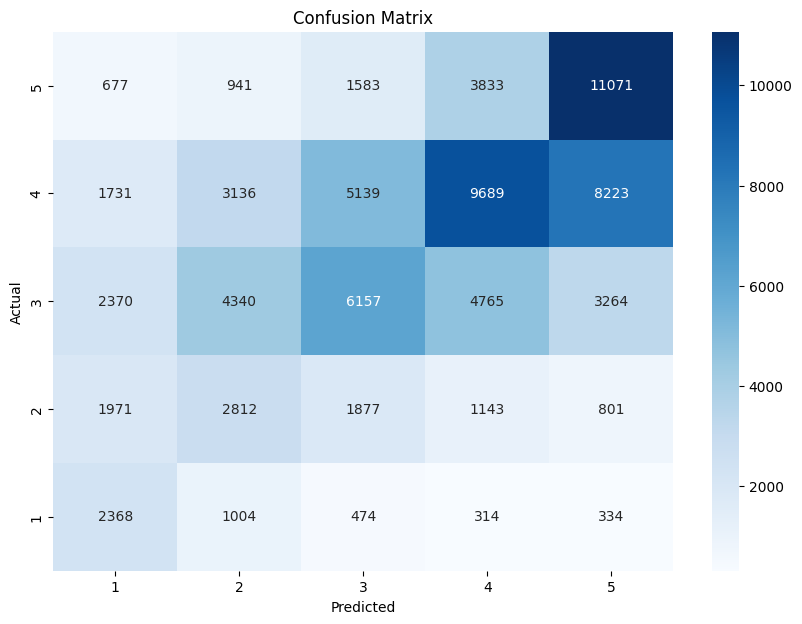

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.show()

ROC AUC Scores for each class:
1: 0.7188
2: 0.5975
3: 0.5706
4: 0.5770
5: 0.7038


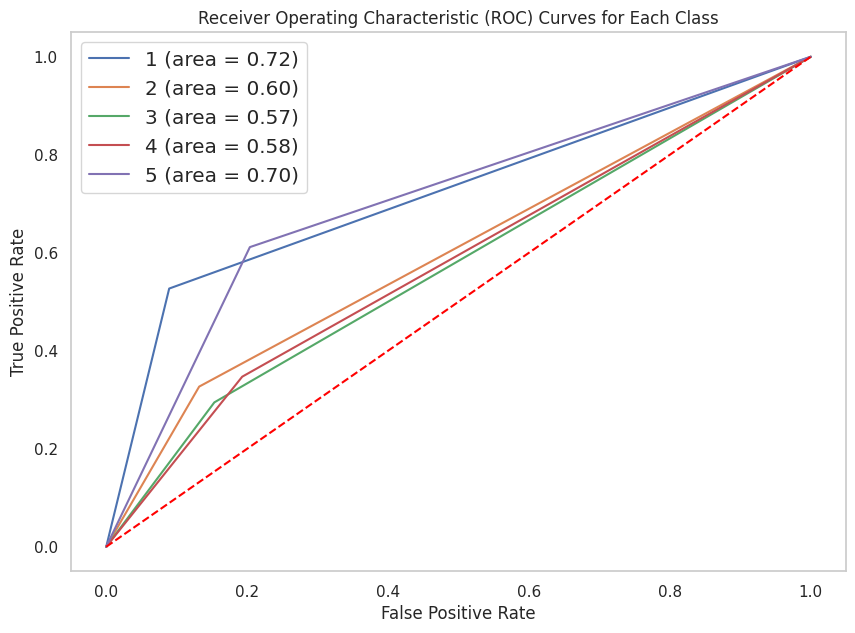

In [ ]:
# Binarize the output for multi-class ROC AUC and other metrics
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
test_predictions_bin = label_binarize(test_predictions, classes=range(len(class_names)))

# ROC AUC Score for each class
roc_auc_dict = {}
for i in range(len(class_names)):
    roc_auc_dict[class_names[i]] = roc_auc_score(y_test_bin[:, i], test_predictions_bin[:, i])

print("ROC AUC Scores for each class:")
for class_name, score in roc_auc_dict.items():
    print(f"{class_name}: {score:.4f}")

# ROC Curves for each class
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_predictions_bin[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_dict[class_names[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
plt.legend(fontsize='large')
plt.grid(False)
plt.show()


In [ ]:
# Log Loss
logloss = log_loss(y_test_bin, test_predictions_bin)
print(f"Log Loss: {logloss:.4f}")

# Brier Score Loss for each class
brier_scores = {}
for i in range(len(class_names)):
    brier_scores[class_names[i]] = brier_score_loss(y_test_bin[:, i], test_predictions_bin[:, i])

print("Brier Scores for each class:")
for class_name, score in brier_scores.items():
    print(f"{class_name}: {score:.4f}")

Log Loss: 21.5856
Brier Scores for each class:
1: 0.1109
2: 0.1901
3: 0.2976
4: 0.3535
5: 0.2456


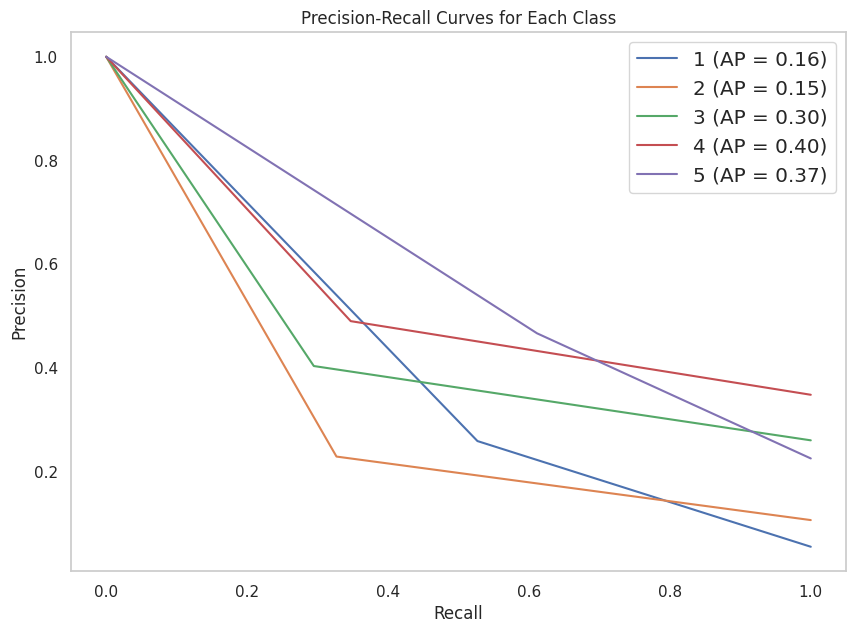

In [ ]:
# Binarize the output for multi-class Precision-Recall curves
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
test_predictions_bin = label_binarize(test_predictions, classes=range(len(class_names)))

# Precision-Recall curves for each class
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], test_predictions_bin[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], test_predictions_bin[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(fontsize='large')
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import zero_one_loss
zero_one = zero_one_loss(y_test, test_predictions)
print(f"Zero-One Loss: {zero_one:.4f}")

Zero-One Loss: 0.5989


In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test, test_predictions, target_names=class_names, output_dict=True)
for class_name, metrics in class_report.items():
    if class_name != 'accuracy':
        print(f"Class: {class_name}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")

Class: 1
  precision: 0.26
  recall: 0.53
  f1-score: 0.35
  support: 4494.00
Class: 2
  precision: 0.23
  recall: 0.33
  f1-score: 0.27
  support: 8604.00
Class: 3
  precision: 0.40
  recall: 0.29
  f1-score: 0.34
  support: 20896.00
Class: 4
  precision: 0.49
  recall: 0.35
  f1-score: 0.41
  support: 27918.00
Class: 5
  precision: 0.47
  recall: 0.61
  f1-score: 0.53
  support: 18105.00
Class: macro avg
  precision: 0.37
  recall: 0.42
  f1-score: 0.38
  support: 80017.00
Class: weighted avg
  precision: 0.42
  recall: 0.40
  f1-score: 0.40
  support: 80017.00
